想要了解该内容的看客们一定对DGA相关内容有一定了解了，这里就不再赘述，只是做简单说明。

僵尸网络中用来控制主机，负责处理信息，下发任务的中心机器，也称C&C服务器（control & command）。一个成熟的僵尸网络往往具有多个C&C服务 器。
对于安全人员来说，查杀了僵尸网络的C&c服务器也就等于毁灭而这个僵尸网络，那么作为安全对抗，僵尸网络的缔造者也会想尽办法对其进行隐藏和保护其主控端。

那么对于固定的C&C服务器域名，安全人员一般来说很容易对其进行查杀，因此，基于DGA方法僵尸网络也就产生了，DGA全程随机域名生成算法，是指使用主控端和被控端协商好的一种基于随机算法的域名生成协议，简单来说就是生成一个随机字符串来作为域名并进行注册，将其作为C&C服务器的域名并不定时经常性更换。由于具备强随机性，短时效性，通过DGA生成的域名往往在查杀上更具备难度。

使用机器学习的方法来对DGA域名进行查杀，业界已有实现；笔者首次接触实在2016年wooyun年会上，phunter神做的一篇报告，在报告中他详细介绍了包括二层，三层flux方法等在内的诸多高级生成DGA方法，并从数学上介绍了一些生成算法以及机器学习的检测方法.本文是参考https://github.com/phunterlau/dga_classifier 的一个简单实现版本，本文全部代码可以在 笔者GitHub项目中查看https://github.com/0FuzzingQ/dga_check


In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import argparse
from load import load_data
from common import getshan,getyuanyin,getroot,getrootclass,getlen,getw2v
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn import cross_validation
from sklearn.svm import SVC
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

C:\Users\aldin\AppData\Roaming\Python\Python36\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\program files\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
method = 'train'
path = 'train.txt'

本次使用训练集位于train.txt中，共包含10w正常url数据以及15w 使用DGA算法生成的域名数据
首先载入数据集看一下数据集情况

In [3]:
train_data = load_data(path,method)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249999 entries, 0 to 249998
Data columns (total 2 columns):
label     249999 non-null object
domain    249999 non-null object
dtypes: object(2)
memory usage: 3.8+ MB


In [5]:
train_data.head(5)

,label,domain
0,0,facebook.com
1,0,youtube.com
2,0,yahoo.com
3,0,baidu.com
4,0,wikipedia.org


In [6]:
train_data.tail(5)

,label,domain
249994,1,zzznnx.ir
249995,1,zzztqrq.ht
249996,1,zzzvr.su
249997,1,zzzwtef.com.pa
249998,1,zzzzuvfbt.co.uk


可以看到正常域名都是大家比较熟悉的那些，Google，youtube等等,恶意域名，感觉就很奇怪，而且...根域名更奇怪，根域名，也许可以看成是一个特征向量也说不定

那么就先把根域名尝试作为一个特征吧，探测一下！周所周知，正大光明的网站一般使用正大光明的域名，比如说很常见的如com;cn;org;cc；net等等，因此我们把这个作为一个点来分类；由于是一个简单的项目，我们不是用one-hot编码,频率编码等手段，仅仅依照经验将其分为常见，不常见两个类别

注：本文的功能函数代码均位于github中common.py文件中，本notebook仅仅演示主要的机器学习的使用流程和手法

以下第一行代码用于获取每一个域名的根域名并加入DataFrame中
第二行代码用于分类并将类别信息加入DataFrame中

In [7]:
train_data['root'] = train_data['domain'].map(lambda x:getroot(x)).astype(str)
train_data['rootclass'] = train_data['root'].map(lambda x:getrootclass(x)).astype(int)

再看一下数据情况，会发现咱们原本的DataFrame多了两列信息，就是我们刚才加上去的~

In [8]:
train_data.head(5)

,label,domain,root,rootclass
0,0,facebook.com,com,0
1,0,youtube.com,com,0
2,0,yahoo.com,com,0
3,0,baidu.com,com,0
4,0,wikipedia.org,org,0


In [9]:
train_data.tail(5)

,label,domain,root,rootclass
249994,1,zzznnx.ir,ir,1
249995,1,zzztqrq.ht,ht,1
249996,1,zzzvr.su,su,1
249997,1,zzzwtef.com.pa,pa,1
249998,1,zzzzuvfbt.co.uk,uk,1


有没有发现看上去好像正常域名的rootclass都等于0，不正常的都等于1；
感觉好像是的！那么我们来画个图看一看再整个数据集上的分布吧

python科学计算可视化神器 matplotlib和seaborn

In [10]:
suby = train_data.label.values
subx = train_data.rootclass.values

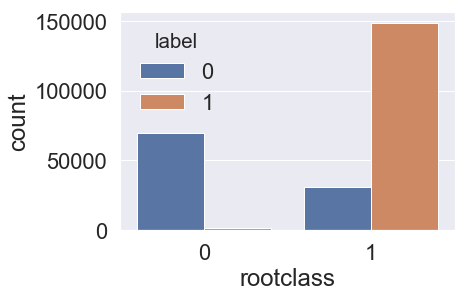

In [11]:
sns.countplot(x='rootclass', hue='label',data=train_data)

ok 很明显可以看出来数据分布上的差异了，在正常样本上也就是label=0时，常见根域名出现的概率远远大于非正常域名，几乎可以说是忽略不计，而对于不正常域名label=1时，非常见根域名出现的概率大概是正常域名的4-5倍，

所以我们完全可以将根域名作为我们模型的一个特征
PS：笔者采用的这种方法是较为简陋的一种，更科学地特征工程可以更好的挖掘这一特征

接下来挖掘一些其他可能的特征，比如说最简单的，长度？

试试看，还是使用一样的思路，将每一条域名的长度计算出来来，作为一列加入到我们的train_data中，并采用可视化的方法来看一看域名的长度是否在不同label上有着不同的分布

以下代码用于计算每个域名的长度并返回结果，作为train_data中的一列

In [12]:
train_data['len'] = train_data['domain'].map(lambda x:getlen(x)).astype(int)

In [13]:
train_data.head(10)

,label,domain,root,rootclass,len
0,0,facebook.com,com,0,12
1,0,youtube.com,com,0,11
2,0,yahoo.com,com,0,9
3,0,baidu.com,com,0,9
4,0,wikipedia.org,org,0,13
5,0,qq.com,com,0,6
6,0,linkedin.com,com,0,12
7,0,taobao.com,com,0,10
8,0,twitter.com,com,0,11
9,0,live.com,com,0,8


In [14]:
train_data.tail(10)

,label,domain,root,rootclass,len
249989,1,zzzewwhfc.com.hn,hn,1,16
249990,1,zzzgx.co.vi,vi,1,11
249991,1,zzzjxt.as,as,1,9
249992,1,zzzkf.tc,tc,1,8
249993,1,zzzlxtam.co.kr,kr,1,14
249994,1,zzznnx.ir,ir,1,9
249995,1,zzztqrq.ht,ht,1,10
249996,1,zzzvr.su,su,1,8
249997,1,zzzwtef.com.pa,pa,1,14
249998,1,zzzzuvfbt.co.uk,uk,1,15


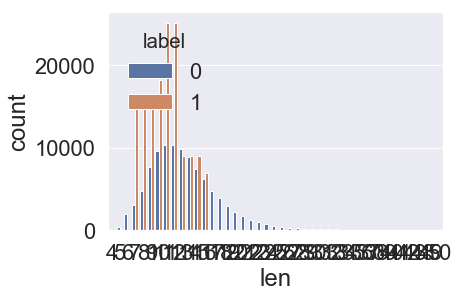

In [15]:
sns.countplot(x='len', hue='label',data=train_data)

我们可以发现非正常域名的长度分布更加集中，而正常域名分布更像是一个正态分布，ok,把他作为一个特征

下一步要想一想还有什么特征
信息学中有一个很重要的概念，叫熵（虽然它最早出自化学和物理学2333），在信息学中，它用于衡量一个系统的混乱程度，简而言之，对于一个随机字符串，他就代表着字符串中字母出现以及分布的混乱程度，打个比方:
str1 = 'aaabbb'
str2 = 'asdfgh'
两者长度相同，可是看上去str1比str2更整齐，更有规律不少，而str2更像是用脸滚键盘滚出来的，熵主要用于判断器混乱程度，不同于我们用肉眼判断，她有一个著名的公式，叫香农熵公式:

G = -ΣLog(P(Xi)) * P(Xi)

其中P(Xi)是字符出现的概率 比如 str1中 P('a') = 3 / (3+3) = 0.5  str2中 P('a') = 1 / (6) = 0.166667 

In [16]:
train_data['shan'] = train_data['domain'].map(lambda  x:getshan(x)).astype(float)

In [17]:
train_data.head(5)

,label,domain,root,rootclass,len,shan
0,0,facebook.com,com,0,12,3.022055
1,0,youtube.com,com,0,11,3.095795
2,0,yahoo.com,com,0,9,2.641604
3,0,baidu.com,com,0,9,3.169925
4,0,wikipedia.org,org,0,13,3.334679


In [18]:
train_data.tail(5)

,label,domain,root,rootclass,len,shan
249994,1,zzznnx.ir,ir,1,9,2.419382
249995,1,zzztqrq.ht,ht,1,10,2.446439
249996,1,zzzvr.su,su,1,8,2.405639
249997,1,zzzwtef.com.pa,pa,1,14,3.324863
249998,1,zzzzuvfbt.co.uk,uk,1,15,3.106891


sns.pointplot(x='label', y='shan',data=train_data)

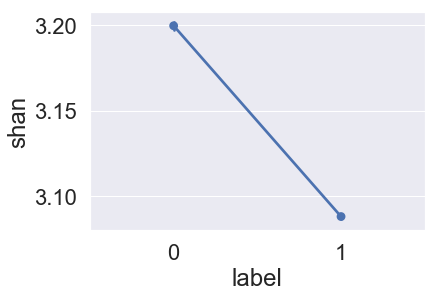

In [19]:
sns.pointplot(x='label', y='shan',data=train_data)

接下来还有什么参数呢，plunter的原文从语言学提供了提供了一些新的思路，比如说 好读

没错，根据常规来说一个正常的网站一定会希望他的网站域名是读起来朗朗上口并且好记的，根据语言学和音韵学来说，貌似在字符中插入一定的元音字母会让一个字符串卡萨诺航区或者读起来更像是一个单词一样，元音是啥 a e i o u ，比如说 baidu 五个字母中有3个都是元音 再比如说 google 六个字母中有3个元音，比如说zzzzuvfbt  9个单词中只有一个元音...

看上去这会是一个好的特征 我们来看看！
以下一行代码用于计算元音字母所占的比例

In [20]:
train_data['yuan_ratio'] = train_data['domain'].map(lambda x:getyuanyin(x)).astype(float)

In [21]:
train_data.head(5)

,label,domain,root,rootclass,len,shan,yuan_ratio
0,0,facebook.com,com,0,12,3.022055,0.454545
1,0,youtube.com,com,0,11,3.095795,0.500000
2,0,yahoo.com,com,0,9,2.641604,0.500000
3,0,baidu.com,com,0,9,3.169925,0.500000
4,0,wikipedia.org,org,0,13,3.334679,0.500000


In [22]:
train_data.tail(5)

,label,domain,root,rootclass,len,shan,yuan_ratio
249994,1,zzznnx.ir,ir,1,9,2.419382,0.125000
249995,1,zzztqrq.ht,ht,1,10,2.446439,0.000000
249996,1,zzzvr.su,su,1,8,2.405639,0.142857
249997,1,zzzwtef.com.pa,pa,1,14,3.324863,0.250000
249998,1,zzzzuvfbt.co.uk,uk,1,15,3.106891,0.230769


结果显而易见 正常域名中元音所占的比率远远大于非正常域名！

OK，暂时想不到其他的什么特征了，就用这几个建立一个demo版本吧

特征有了，下一步干啥呢

归一化咯，所谓归一化，就是不数据的范围放缩至一个相同的范围以避免数据跨度或量级的巨大差别而导致训练上的困难或者结果上的偏差
sklearn给出了丰富强大的接口来帮你

In [23]:
scaler = preprocessing.StandardScaler()
len_scale_param = scaler.fit(train_data['len'].values.reshape(-1,1))
train_data['len_scaled'] = scaler.fit_transform(train_data['len'].values.reshape(-1,1),len_scale_param)
shan_scale_param = scaler.fit(train_data['shan'].values.reshape(-1,1))
train_data['shan_sclaed'] = scaler.fit_transform(train_data['shan'].values.reshape(-1,1),shan_scale_param)

c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


ok 现在看一下我们在经过特征工程和数据预处理以后的数据长啥样吧

In [24]:
train_data.head(5)

,label,domain,root,rootclass,len,shan,yuan_ratio,len_scaled,shan_sclaed
0,0,facebook.com,com,0,12,3.022055,0.454545,0.043608,-0.341005
1,0,youtube.com,com,0,11,3.095795,0.500000,-0.237871,-0.113708
2,0,yahoo.com,com,0,9,2.641604,0.500000,-0.800828,-1.513712
3,0,baidu.com,com,0,9,3.169925,0.500000,-0.800828,0.114791
4,0,wikipedia.org,org,0,13,3.334679,0.500000,0.325087,0.622631


看上去是一些靠谱的特征了，那么最后一步，把我们需要的特征都拿出来，带入模型训练

首先，我们需要的列：rootclass,yuan_ratio,len_scaled,shan_scaled是我们所需要的，把他们拿出来，转化成numpy矩阵的格式

In [25]:
train_pre = train_data.filter(regex = 'label|yuan_ratio|len_scaled|shan_scale_param|rootclass')
train_pre = shuffle(train_pre)

shuffle()是一个很好用的函数，他将帮你把你的数据集打乱顺序，避免相同label的数据都堆积在一起

好啦！接下来，我们把数据转化成矩阵，并且切分成训练集和测试集（正常来说还应该有一个数据集叫做验证集，本例只作简单演示，就去掉啦）

In [26]:
train_pre =train_pre.as_matrix()
y_train = train_pre[0:200000,0]
x_train = train_pre[0:200000,1:]
y_test = train_pre[200000:201000,0]
x_test = train_pre[200000:201000,1:]

C:\Users\aldin\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


OK  数据处理的过程到这里就已经全部结束了，接下来要做的，就是选择一个合适的模型进行训练了

本次我们选择经典的SVM函数，并选择RBF作为核方法

In [28]:
model = SVC(kernel='rbf',C=0.4).fit(x_train,y_train)
print ('training finished')

training finished


In [30]:
pre = cross_validation.cross_val_score(model,x_test,y_test,cv = 5)
print (pre)

[0.88059701 0.87       0.865      0.9        0.89447236]


使用测试机集做了一哈验证，平均准确率在88%上下，emmmm 效果差强人意，毕竟只是一个小样例，要求不能太高哈23333

本篇over 如果想了解关机器学习算法  可以参考 李航博士的 《统计学习方法》 和周志华教授的 《机器学习》

下一篇将会尝试使用深度学习的方法完成这一任务并大大提升准确率